## Classification

Let us to train a model to classify ants and bees. The dataset can be downloaded from https://download.pytorch.org/tutorial/hymenoptera_data.zip

This dataset is more realistic than MNIST. We will use this dataset to see how we can train deep neural networks end to end. 

Note that this dataset is small. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Deep Neural Networks typically require much more data to generalize.  However we will not be training the model from scratch. Instead we will be finetuning, which is a technique that every Deep Learning practitioner should know.  

How does finetuning work?
Instead of initializing the weights of the model from scratch/ randomly, we instead initialize it with the weights of an already trained model (pretrained model). The pretrained model is one that has been trained on a very large dataset (Like ImageNet, which has trained on >1 million images across 1000 classes). 

In [1]:
import os
import torch
import torchmetrics
import torchvision
import pytorch_lightning as pl
import urllib.request
import matplotlib.pyplot as plt
import numpy as np


from pytorch_lightning import LightningDataModule, LightningModule, Trainer
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from pytorch_lightning.callbacks import ModelCheckpoint

In [2]:
pl.seed_everything(42)

Global seed set to 42


42

As always, let us write the data module to download and load this dataset. 

In [3]:
class InsectsDataModule(LightningDataModule):
    DATASET_DIR = "datasets"
    def __init__(self, train_transform=None, val_transform=None, batch_size=4):
        if train_transform is None:
            # By default, let us augment the data
            # We use RandomResizedCrop which takes a random crop of the image and resizes it to 224
            # And RandomHorizontalFlip which flips the image horizontally.
            train_transform = transforms.Compose([
                                    transforms.RandomResizedCrop(224, (0.4, 1.0)),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                    ])
        self.train_transform = train_transform
        if val_transform is None:
            val_transform = transforms.Compose([
                                    transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                    ])
        self.val_transfomr = val_transform
        self.dataset_path = os.path.join(InsectsDataModule.DATASET_DIR,"hymenoptera_data")
        self.batch_size = batch_size
        
    def prepare_data(self):
        if os.path.exists(self.dataset_path):
            # If the dataset already exists, no need to redownload.
            return 
        url = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
        zip_path = os.path.join(InsectsDataModule.DATASET_DIR, "hymenoptera_data.zip")
        urllib.request.urlretrieve(url, zip_path)
        os.system(f"unzip {zip_path} -d {InsectsDataModule.DATASET_DIR}/")
    
    def setup(self, stage=None):
        self.train_dataset = datasets.ImageFolder(os.path.join(self.dataset_path, "train"),
                                                 transform=self.train_transform)
        self.val_dataset = datasets.ImageFolder(os.path.join(self.dataset_path, "val"),
                                                 transform=self.val_transfomr)
        self.classes = self.train_dataset.classes
        
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, 
                          shuffle=True, num_workers=0) 
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, 
                          shuffle=True, num_workers=0) 
        
    @property
    def num_classes(self):
        return 2

Let us visualize the data and see how the training data looks

In [4]:
dm = InsectsDataModule()
dm.prepare_data()
dm.setup()

train_dataloader = dm.train_dataloader()
X, y_gt = next(iter(train_dataloader))

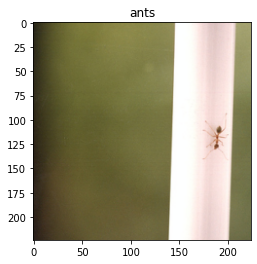

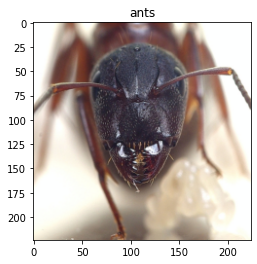

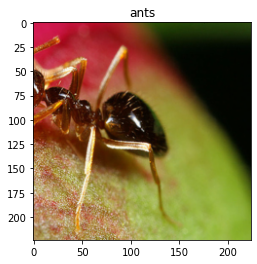

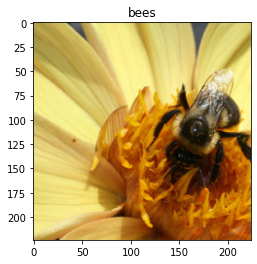

In [5]:
def visualize(X, y_gt, classes):
    for i, img in enumerate(X):
        img = img.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        # The image tensors are normalized.
        # In order to display the images, we need to denormalize them. This is done
        # by reversing the normalization i.e multiplying by std and add to the mean.
        img = std * img + mean
        img = np.clip(img, 0, 1)
        plt.figure()
        plt.title(classes[y_gt[i]])
        plt.imshow(img)
visualize(X, y_gt, dm.classes)

## Building the classifier

`torchvision.models` already comes built in with support for multiple architectures and pretrained models for a wide variety of problems ranging from classification, object detection , segmentation.  More details can be found at https://pytorch.org/vision/stable/models.html

Let us leverage this to build our classifer. We will build a classifier that supports both VGG and Resnet architectures. As always, this is done by defining our Lightning module.

In [6]:
class SimpleClassifier(LightningModule):
    def __init__(self, model_type, num_classes):
        super(SimpleClassifier, self).__init__()
        
        self.save_hyperparameters()
        
        supported_architectures = {
                "resnet18": models.resnet18,
                "resnet50": models.resnet50,
                "resnet101": models.resnet101,
                "resnet152": models.resnet152,
                "vgg11": models.vgg11,
                "vgg16": models.vgg16,
                "vgg19": models.vgg19
            }
        assert model_type in supported_architectures, f"{model_type} is not supported"
        # We download the pretrained model of the required architecture
        self.base_model = supported_architectures[model_type](pretrained=True)
        if "resnet" in model_type:
            # The pretrained ResNet model is trained on Imagenet and is thus trained to emit 1000 classes
            # So we need to change the architecture to emit num_classes.
            
            # Extract last FC layer
            last_layer = self.base_model.fc
            last_layer_in,  last_layer_out = last_layer.in_features, last_layer.out_features
            assert last_layer_out == 1000
            
            # Change the last FC layer to emit num_classes instead
            self.base_model.fc = torch.nn.Linear(last_layer_in, num_classes) 
            
            
        elif "vgg" in model_type:
            # The pretrained VGG model is trained on Imagenet and is thus trained to emit 1000 classes
            # So we need to change the architecture to emit num_classes.
            
            last_layer = self.base_model.classifier[-1]
            last_layer_in,  last_layer_out = last_layer.in_features, last_layer.out_features
            assert last_layer_out == 1000
            
            # Change the last FC layer to emit num_classes instead
            self.base_model.classifier[-1] = torch.nn.Linear(last_layer_in, num_classes) 
        else:
            raise NotImplementedError(f"{model_type} not supported")
        
        self.criterion = torch.nn.CrossEntropyLoss()
        self.accuracy = torchmetrics.Accuracy()
    
    def forward(self, X):
        """
        The forward method implements the forward pass of the model. In this case
        the input is a batch of images, and the output is the logits
        """
        return self.base_model(X)
    
    def predict(self, X):
        """
        Predict runs the forward pass, performs softmax to convert the resulting logits into
        probabilities and returns the class with the highest probability.
        """
        logits = self.forward(X)
        probs = torch.softmax(logits, dim=1)
        return torch.argmax(probs, 1)
    
    def core_step(self, batch):
        """
        Both the training and test loops involve the forward pass, computation of loss
        and accuracy. Let us abstract it out and implement it under this method.
        """
        X, y_true = batch
        y_pred_logits = self.forward(X)
        loss = self.criterion(y_pred_logits, y_true)
        accuracy = self.accuracy(y_pred_logits, y_true)
        return loss, accuracy
    
        
    def training_step(self, batch, batch_idx):
        """
        This method implements the basic training step. We will run forward pass, compute 
        loss, accuracy. We will log any necessary values, and return the total loss.
        """
        loss, accuracy = self.core_step(batch)
        if self.global_step % 100 == 0:
            self.log("train_loss", loss, on_step=True, on_epoch=True)
            self.log("train_accuracy", accuracy, on_step=True, on_epoch=True)
        return loss
    
    def validation_step(self, batch, batch_idx, dataset_idx=None):
        """
        This method implements the basic validation step. We will run the forward pass, compute the loss
        and accuracy and return it.
        """
        return self.core_step(batch)
    
    def validation_epoch_end(self, outputs):
        """
        This method will be called at the end of all test steps for each epoch i.e the validation epoch end.
        The output of every single test_step is available to via outputs. 
        
        Here we will compute the average test loss and accuracy by simply averaging across all test batches
        """
        avg_loss = torch.tensor([x[0] for x in outputs]).mean()
        avg_accuracy = torch.tensor([x[1] for x in outputs]).mean()
        self.log("val_loss", avg_loss)
        self.log("val_accuracy", avg_accuracy)
        print(f"Epoch {self.current_epoch}, Val loss: {avg_loss:0.2f}, Accuracy: {avg_accuracy:0.2f}")
        return avg_loss
    
    def configure_optimizers(self):
        """
        The optimizer will be configured in this method
        """
        
        optimizer = torch.optim.SGD(self.base_model.parameters(), lr=0.001, momentum=0.9)
        
        # Decay LR by a factor of 0.1 every 3 epochs
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
        return {
            "optimizer": optimizer,
            "lr_scheduler": lr_scheduler
        }
    
    def checkpoint_callback(self):
        """
        This callback determines the logic for how we want to checkpoint / save the model
        """
        # We will save the model with the best val accuracy and the last model
        return ModelCheckpoint(monitor="val_accuracy", mode="max", save_top_k=1, save_last=True)

Let us now create the model and look at the architecture. Note how simple it is to choose from a wide variety of architectures ranging from ResNet18 to VGG16. Other architectures can also be supported accordingly.

In [7]:
model_type = "resnet18"
model = SimpleClassifier(model_type, dm.num_classes)
model

SimpleClassifier(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

Let us now the train the model. We will only train for 10 epochs for the purpose of this tutorial. This takes a few minutes on CPU.  The model will obviously get better with more epochs.

In [8]:
exp_dir = "/tmp/ants_vs_bees"
checkpoint_callback = model.checkpoint_callback()
 
trainer = Trainer(
        default_root_dir=exp_dir, # The experiment directory
        callbacks=[checkpoint_callback],
        gpus=torch.cuda.device_count(), # Number of GPUs to run on
        max_epochs=10,
        num_sanity_val_steps=0
    )
trainer.fit(model, dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/ananya.h.a/.virtualenvs/dl_book/lib/python3.7/site-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "

  | Name       | Type             | Params
------------------------------------------------
0 | base_model | ResNet           | 11.2 M
1 | criterion  | CrossEntropyLoss | 0     
2 | accuracy   | Accuracy         | 0     
------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.710    Total estimated model params size (MB)
/Users/ananya.h.a/.virtualenvs/dl_book/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: T

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch 0, Val loss: 0.25, Accuracy: 0.90


Validating: 0it [00:00, ?it/s]

Epoch 1, Val loss: 0.75, Accuracy: 0.74


Validating: 0it [00:00, ?it/s]

Epoch 2, Val loss: 0.28, Accuracy: 0.90


Validating: 0it [00:00, ?it/s]

Epoch 3, Val loss: 0.18, Accuracy: 0.94


Validating: 0it [00:00, ?it/s]

Epoch 4, Val loss: 0.23, Accuracy: 0.90


Validating: 0it [00:00, ?it/s]

Epoch 5, Val loss: 0.14, Accuracy: 0.94


Validating: 0it [00:00, ?it/s]

Epoch 6, Val loss: 0.15, Accuracy: 0.96


Validating: 0it [00:00, ?it/s]

Epoch 7, Val loss: 0.17, Accuracy: 0.93


Validating: 0it [00:00, ?it/s]

Epoch 8, Val loss: 0.14, Accuracy: 0.94


Validating: 0it [00:00, ?it/s]

Epoch 9, Val loss: 0.14, Accuracy: 0.94


Let us now look at the predictions of the model.  We will also look at how to finetune and predict from this from this model.

In [9]:
best_model_path = checkpoint_callback.best_model_path
# Let us load the model from the best model weights that we have
trained_model = SimpleClassifier.load_from_checkpoint(best_model_path, model_type=model_type, num_classes=dm.num_classes)
trained_model.eval()

val_dataloader = dm.val_dataloader()

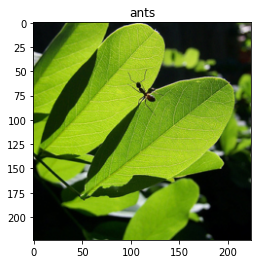

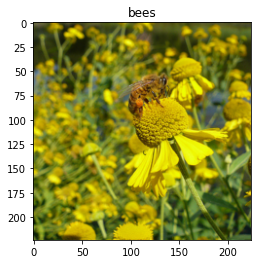

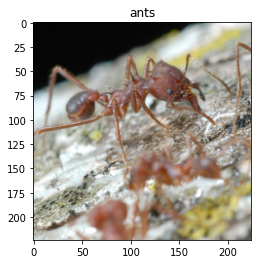

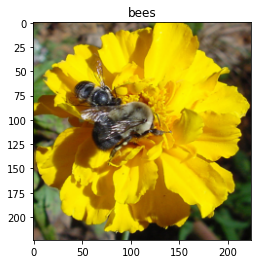

In [10]:
X, y_gt = next(iter(val_dataloader))
y_pred = trained_model.predict(X)
visualize(X, y_pred, dm.classes)